In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import spherical_jn, spherical_yn
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import integrate

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [30]:
# 1. Define Physical Constants
c = 3e8  # Speed of light in vacuum (m/s)
epsilon_0 = 8.85e-12  # Vacuum permittivity (F/m)
mu_0 = 1.257e-6  # Vacuum permeability (H/m)

In [31]:
# Radar Parameters
# S-band radar (typical for weather radar)
radar_freq = 2.8e9  # Radar frequency (Hz)
radar_wavelength = c / radar_freq  # Radar wavelength (m)
radar_wavenumber = 2 * np.pi / radar_wavelength  # Radar wavenumber (1/m)

print(f"Radar Wavelength: {radar_wavelength:.4f} m")
print(f"Radar Wavenumber: {radar_wavenumber:.4f} 1/m")


Radar Wavelength: 0.1071 m
Radar Wavenumber: 58.6431 1/m


In [32]:
### Implementing dielectric properties of water, ice, mixtures
def complex_permittivity_water(temp_celsius, frequency_hz):
    static_permittivity = 88.15 - 0.414 * temp_celsius
    high_freq_permittivity = 5.5
    relaxation_time = 1.1109e-10 - 3.824e-12 * temp_celsius
    
    omega = 2 * np.pi * frequency_hz
    
    real_part = high_freq_permittivity + (static_permittivity - high_freq_permittivity) / (1 + (omega * relaxation_time)**2)
    imag_part = omega * relaxation_time * (static_permittivity - high_freq_permittivity) / (1 + (omega * relaxation_time)**2)
    
    return complex(real_part, -imag_part)

In [33]:
def complex_permittivity_ice(temp_celsius, frequency_hz):
    """
    Calculate the complex permittivity of ice at a given temperature and frequency.
    
    Args:
        temp_celsius: Temperature in Celsius
        frequency_hz: Frequency in Hz
        
    Returns:
        Complex permittivity of ice
    """
    # Ice parameters
    static_permittivity = 3.17  # Static permittivity of ice
    loss_tangent = 0.0009  # Loss tangent at 0°C (approximation)
    
    
    # Temperature adjustment
    if temp_celsius < 0:
        loss_tangent *= 1 - 0.01 * temp_celsius  # Loss increases with lower temperatures
    
    # Calculate complex permittivity
    real_part = static_permittivity
    imag_part = static_permittivity * loss_tangent
    
    return complex(real_part, -imag_part)


In [34]:
def complex_permittivity_hail(ice_fraction, temp_celsius, frequency_hz):
    """
    Calculate complex permittivity for hail (mixture of ice and water).
    Uses the Maxwell-Garnett mixing formula.
    
    Args:
        ice_fraction: Volume fraction of ice (0-1)
        temp_celsius: Temperature in Celsius
        frequency_hz: Frequency in Hz
        
    Returns:
        Complex permittivity of the hail mixture
    """
    eps_ice = complex_permittivity_ice(temp_celsius, frequency_hz)
    eps_water = complex_permittivity_water(temp_celsius, frequency_hz)
    
    # Maxwell-Garnett mixing formula (water as host medium, ice as inclusions)
    if ice_fraction > 0.5:  # If more ice than water, swap the host medium
        eps_host = eps_ice
        eps_inclusion = eps_water
        inclusion_fraction = 1 - ice_fraction
    else:
        eps_host = eps_water
        eps_inclusion = eps_ice
        inclusion_fraction = ice_fraction
    
    # Maxwell-Garnett formula
    numerator = eps_inclusion - eps_host
    denominator = eps_inclusion + 2 * eps_host
    factor = 3 * eps_host * inclusion_fraction * (numerator / denominator)
    
    return eps_host * (1 + factor) / (1 - inclusion_fraction * (numerator / denominator))

### Mie Scattering 

In [35]:
def mie_coefficient_an(n, size_param, m):
    """
    Calculates Mie Coefficient

    Args:
        n : Order of mie coefficient
        size_param: Size parameter
        m: Relative refractive index
    Returns:
    mie_coefficient: Mie coefficient
    """
    mx = m * size_param
    jnx = spherical_jn(n, size_param)
    jnmx = spherical_jn(n, mx)
    
    jnx_der = spherical_jn(n, size_param, derivative=True)
    jnmx_der = spherical_jn(n, mx, derivative=True)
    
    hnx = spherical_jn(n, size_param) + 1j * spherical_yn(n, size_param)
    hnx_der = spherical_jn(n, size_param, derivative=True) + 1j * spherical_yn(n, size_param, derivative=True)
    
    numerator = m * jnmx * jnx_der - jnx * jnmx_der
    denominator = m * jnmx * hnx_der - hnx * jnmx_der
    
    return numerator / denominator
    

In [36]:
def mie_coefficient_bn(n, size_param, m):
    """
    Calculate Mie coefficient b_n.
    
    Args:
        n: Order of the Mie coefficient
        size_param: Size parameter (x = k*a)
        m: Relative refractive index
        
    Returns:
        Mie coefficient b_n
    """
    mx = m * size_param
    jnx = spherical_jn(n, size_param)
    jnmx = spherical_jn(n, mx)
    
    jnx_der = spherical_jn(n, size_param, derivative=True)
    jnmx_der = spherical_jn(n, mx, derivative=True)
    
    hnx = spherical_jn(n, size_param) + 1j * spherical_yn(n, size_param)
    hnx_der = spherical_jn(n, size_param, derivative=True) + 1j * spherical_yn(n, size_param, derivative=True)
    
    numerator = jnmx * jnx_der - m * jnx * jnmx_der
    denominator = jnmx * hnx_der - m * hnx * jnmx_der
    
    return numerator / denominator


In [37]:
def mie_scattering_cross_section(diameter, wavelength, n_medium, n_particle, max_n=20):
    """
    Calculate Mie scattering cross-section.
    
    Args:
        diameter: Particle diameter (m)
        wavelength: Wavelength (m)
        n_medium: Refractive index of medium
        n_particle: Complex refractive index of particle
        max_n: Maximum number of terms in the Mie series
        
    Returns:
        Scattering cross-section
    """
    # Calculate size parameter and relative refractive index
    radius = diameter / 2
    k = 2 * np.pi * n_medium / wavelength
    size_param = k * radius
    m = n_particle / n_medium
    
    # Initialize cross-section
    sigma_sca = 0
    
    # Sum over n terms
    for n in range(1, max_n + 1):
        an = mie_coefficient_an(n, size_param, m)
        bn = mie_coefficient_bn(n, size_param, m)
        sigma_sca += (2*n + 1) * (np.abs(an)**2 + np.abs(bn)**2)
    
    # Multiplicative factor
    sigma_sca *= (2 * np.pi / (k**2)) 
    
    return sigma_sca

In [38]:
def mie_backscatter_cross_section(diameter, wavelength, n_medium, n_particle, max_n=20):
    """
    Calculate Mie backscattering cross-section.
    
    Args:
        diameter: Particle diameter (m)
        wavelength: Wavelength (m)
        n_medium: Refractive index of medium
        n_particle: Complex refractive index of particle
        max_n: Maximum number of terms in the Mie series
        
    Returns:
        Backscattering cross-section
    """
    # Calculate size parameter and relative refractive index
    radius = diameter / 2
    k = 2 * np.pi * n_medium / wavelength
    size_param = k * radius
    m = n_particle / n_medium
    
    # Initialize sum for backscattering coefficient
    backscatter_sum = 0
    
    # Sum over n terms
    for n in range(1, max_n + 1):
        an = mie_coefficient_an(n, size_param, m)
        bn = mie_coefficient_bn(n, size_param, m)
        backscatter_sum += (2*n + 1) * (-1)**n * (an - bn)
    
    # Calculate backscattering cross-section
    sigma_b = (np.pi / (k**2)) * np.abs(backscatter_sum)**2
    
    return sigma_b


In [39]:

# 4. Rayleigh Scattering Approximation
def rayleigh_scattering_cross_section(diameter, wavelength, refractive_index):
    """
    Calculate Rayleigh scattering cross-section for small particles.
    Valid when particle diameter << wavelength.
    
    Args:
        diameter: Particle diameter (m)
        wavelength: Wavelength (m)
        refractive_index: Complex refractive index of particle
        
    Returns:
        Rayleigh scattering cross-section
    """
    # Calculate particle volume and polarizability
    radius = diameter / 2
    volume = (4/3) * np.pi * radius**3
    
    # Polarizability (for spherical particles)
    K = (refractive_index**2 - 1) / (refractive_index**2 + 2)
    
    # Rayleigh scattering cross-section
    k = 2 * np.pi / wavelength
    sigma_sca = (8/3) * np.pi * k**4 * volume**2 * np.abs(K)**2
    
    return sigma_sca

In [40]:
def rayleigh_backscatter_cross_section(diameter, wavelength, refractive_index):
    """
    Calculate Rayleigh backscattering cross-section.
    
    Args:
        diameter: Particle diameter (m)
        wavelength: Wavelength (m)
        refractive_index: Complex refractive index of particle
        
    Returns:
        Rayleigh backscattering cross-section
    """
    # Calculate particle volume and polarizability
    radius = diameter / 2
    volume = (4/3) * np.pi * radius**3
    
    # Polarizability (for spherical particles)
    K = (refractive_index**2 - 1) / (refractive_index**2 + 2)
    
    # Rayleigh backscattering cross-section
    k = 2 * np.pi / wavelength
    sigma_b = np.pi**5 * diameter**6 * np.abs(K)**2 / wavelength**4
    
    return sigma_b

In [41]:
# 5. T-Matrix Method for Non-Spherical Particles
def t_matrix_simplified(aspect_ratio, equiv_diameter, wavelength, complex_permittivity):
    """
    Simplified T-matrix implementation for spheroidal particles.
    This is a basic approximation that adjusts Mie scattering results based on aspect ratio.
    
    Args:
        aspect_ratio: Ratio of polar to equatorial radii (< 1 for oblate, > 1 for prolate)
        equiv_diameter: Volume-equivalent diameter (m)
        wavelength: Wavelength (m)
        complex_permittivity: Complex permittivity of the particle
        
    Returns:
        Tuple of (scattering cross-section, backscattering cross-section)
    """
    # Calculate equivalent radius and refractive index
    equiv_radius = equiv_diameter / 2
    refractive_index = np.sqrt(complex_permittivity)
    n_medium = 1.0  # Assuming air
    
    # Calculate spherical particle scattering
    sigma_sca_sphere = mie_scattering_cross_section(equiv_diameter, wavelength, n_medium, refractive_index)
    sigma_b_sphere = mie_backscatter_cross_section(equiv_diameter, wavelength, n_medium, refractive_index)
    
    # Apply aspect ratio correction factors
    # This is a simplified approach; full T-matrix would require more complex calculations
    if aspect_ratio < 1:  # Oblate spheroid
        sca_correction = 1 - 0.2 * (1 - aspect_ratio)
        backscatter_correction = 1 - 0.4 * (1 - aspect_ratio)
    else:  # Prolate spheroid
        sca_correction = 1 - 0.1 * (aspect_ratio - 1)
        backscatter_correction = 1 - 0.3 * (aspect_ratio - 1)
    
    # Apply corrections
    sigma_sca = sigma_sca_sphere * sca_correction
    sigma_b = sigma_b_sphere * backscatter_correction
    
    return sigma_sca, sigma_b



In [42]:
### Radar Equation and reflectivity conversion
def radar_reflectivity_factor(backscatter_cross_sections, diameters, volume, wavelength):
    """
    Calculate radar reflectivity factor (Z) from backscattering cross-sections.
    
    Args:
        backscatter_cross_sections: Array of backscattering cross-sections
        diameters: Array of particle diameters (m)
        volume: Sampling volume (m^3)
        
    Returns:
        Radar reflectivity factor Z (mm^6/m^3)
    """
    # Calculate Z from backscatter cross-sections
    k_w = (np.pi**5 * (complex(0.93, 0.23))**2) / wavelength**4  # |K_w|^2 for water
    
    # Reflectivity calculation for each particle
    Z_values = np.zeros_like(backscatter_cross_sections)
    for i, (sigma_b, d) in enumerate(zip(backscatter_cross_sections, diameters)):
        # Convert from backscatter cross-section to reflectivity
        Z_values[i] = (sigma_b * wavelength**4) / (np.pi**5 * k_w)
    
    # Total reflectivity is the sum over all particles in the volume
    Z_total = np.sum(Z_values) / volume
    
    # Convert to mm^6/m^3 (conventional units for Z)
    Z_total *= 1e18  # (m^6/m^3) * 10^18 = mm^6/m^3
    
    return Z_total

In [43]:
def dbz_from_z(Z):
    """
    Convert reflectivity factor Z to dBZ.
    
    Args:
        Z: Reflectivity factor (mm^6/m^3)
        
    Returns:
        Reflectivity in dBZ
    """
    # Avoid log of zero or negative values
    if Z <= 0:
        return -30.0  # Minimum detectable value
    
    return 10 * np.log10(Z)


In [44]:
def differential_reflectivity(h_backscatter, v_backscatter):
    """
    Calculate differential reflectivity (Zdr).
    
    Args:
        h_backscatter: Horizontal polarization backscatter cross-section
        v_backscatter: Vertical polarization backscatter cross-section
        
    Returns:
        Differential reflectivity in dB
    """
    if v_backscatter <= 0:
        return 0  # Avoid division by zero
    
    return 10 * np.log10(h_backscatter / v_backscatter)

In [45]:
def specific_differential_phase(h_fwd_scatter, v_fwd_scatter, num_particles, volume):
    """
    Calculate specific differential phase (Kdp).
    
    Args:
        h_fwd_scatter: Horizontal polarization forward scattering amplitude
        v_fwd_scatter: Vertical polarization forward scattering amplitude
        num_particles: Number of particles in volume
        volume: Sampling volume (m^3)
        
    Returns:
        Specific differential phase (deg/km)
    """
    # Calculate number density
    number_density = num_particles / volume
    
    # Calculate Kdp (simplification)
    wavelength_m = radar_wavelength
    kdp = (180 * wavelength_m * number_density / np.pi) * np.real(h_fwd_scatter - v_fwd_scatter)
    
    # Convert to deg/km
    kdp *= 1000  # Convert from deg/m to deg/km
    
    return kdp


### FDTD Simulation 

In [46]:
def fdtd_1d_simulation(medium_permittivity, domain_length, particle_location, particle_size, particle_permittivity):
    """
    Simplified 1D FDTD simulation for radar wave interaction with a particle.
    
    Args:
        medium_permittivity: Permittivity of the medium
        domain_length: Length of simulation domain (in cells)
        particle_location: Location of particle center (in cells)
        particle_size: Size of particle (in cells)
        particle_permittivity: Complex permittivity of the particle
        
    Returns:
        tuple: (Electric field, Magnetic field, Scattered field)
    """
    # FDTD parameters
    n_steps = 1000  # Number of time steps
    dx = radar_wavelength / 20  # Spatial step size
    dt = dx / (2 * c)  # Time step size (Courant condition)
    
    # Initialize fields
    ez = np.zeros(domain_length)
    hy = np.zeros(domain_length-1)
    
    # Material properties array
    epsilon_r = np.ones(domain_length) * medium_permittivity
    
    # Add particle
    particle_start = int(particle_location - particle_size/2)
    particle_end = int(particle_location + particle_size/2)
    epsilon_r[particle_start:particle_end] = particle_permittivity
    
    # Source parameters (Gaussian pulse)
    t0 = 40
    spread = 12
    
    # Storage for fields over time (for every 10th time step)
    ez_history = np.zeros((n_steps//10 + 1, domain_length))
    hy_history = np.zeros((n_steps//10 + 1, domain_length-1))
    
    # FDTD loop
    for t in range(n_steps):
        # Update magnetic field
        hy[:-1] = hy[:-1] - dt/dx * (ez[1:] - ez[:-1])
        
        # Update electric field
        ez[1:-1] = ez[1:-1] + dt/(dx * epsilon_0 * epsilon_r[1:-1]) * (hy[1:] - hy[:-1])
        
        # Source (soft source)
        source_pos = 10
        ez[source_pos] += np.exp(-0.5 * ((t - t0) / spread)**2)
        
        # Store fields every 10th time step
        if t % 10 == 0:
            ez_history[t//10] = ez.copy()
            hy_history[t//10] = np.append(hy, 0)  # Add zero at the end for plotting
    
    # Calculate scattered field (total field minus incident field)
    # First simulate without particle for incident field
    ez_incident = np.zeros(domain_length)
    hy_incident = np.zeros(domain_length-1)
    
    # Material without particle
    epsilon_r_incident = np.ones(domain_length) * medium_permittivity
    
    # Repeat simulation for incident field
    for t in range(n_steps):
        # Update magnetic field
        hy_incident[:-1] = hy_incident[:-1] - dt/dx * (ez_incident[1:] - ez_incident[:-1])
        
        # Update electric field
        ez_incident[1:-1] = ez_incident[1:-1] + dt/(dx * epsilon_0 * epsilon_r_incident[1:-1]) * (hy_incident[1:] - hy_incident[:-1])
        
        # Source (soft source)
        ez_incident[source_pos] += np.exp(-0.5 * ((t - t0) / spread)**2)
    
    # Calculate scattered field
    ez_scattered = ez - ez_incident
    
    return ez, hy, ez_scattered

In [47]:
# 8. Generate Synthetic Scattering Data for Hail vs. Rain
def generate_synthetic_radar_data(n_samples=100):
    """
    Generate synthetic radar data for hail and rain.
    
    Args:
        n_samples: Number of samples to generate
        
    Returns:
        Pandas DataFrame with synthetic radar data
    """
    # Initialize data arrays
    data = {
        'particle_type': [],
        'diameter_mm': [],
        'reflectivity_dbz': [],
        'differential_reflectivity_db': [],
        'specific_differential_phase_deg_km': [],
        'aspect_ratio': []
    }
    
    # Temperature range
    temps = np.linspace(-10, 20, n_samples)
    
    for i, temp in enumerate(temps):
        # Randomly select particle type
        if i < n_samples/2:
            particle_type = 'rain'
            # Rain droplet parameters
            diameter = np.random.uniform(0.5, 5.0)  # mm
            aspect_ratio = 1.0 - min(0.05 * diameter, 0.2)  # Larger drops more oblate
            ice_fraction = 0.0
        else:
            particle_type = 'hail'
            # Hail parameters
            diameter = np.random.uniform(5.0, 30.0)  # mm
            aspect_ratio = np.random.uniform(0.8, 1.2)  # More variable shapes
            ice_fraction = np.random.uniform(0.7, 1.0)  # Mostly ice
        
        # Convert to meters for calculations
        diameter_m = diameter / 1000
        
        # Calculate permittivity
        eps_complex = complex_permittivity_hail(ice_fraction, temp, radar_freq)
        refractive_index = np.sqrt(eps_complex)
        
        # Calculate scattering parameters
        if diameter_m < radar_wavelength / 10:  # Small particles: Rayleigh
            sigma_h = rayleigh_backscatter_cross_section(diameter_m, radar_wavelength, refractive_index)
            sigma_v = sigma_h / aspect_ratio  # Approximate vertical cross-section
        else:  # Larger particles: T-matrix
            sigma_sca_h, sigma_h = t_matrix_simplified(aspect_ratio, diameter_m, radar_wavelength, eps_complex)
            sigma_sca_v, sigma_v = t_matrix_simplified(1/aspect_ratio, diameter_m, radar_wavelength, eps_complex)
        
        # Calculate radar parameters
        volume = 1.0  # m^3 (reference volume)
        reflectivity_z = radar_reflectivity_factor([sigma_h], [diameter_m], volume)
        reflectivity_dbz = dbz_from_z(reflectivity_z)
        zdr = differential_reflectivity(sigma_h, sigma_v)
        
        # Approximation for forward scattering (simplified)
        fwd_h = 0.1 * np.sqrt(sigma_h) * (1 + 0.1j)  # Forward scattering amplitude (complex)
        fwd_v = 0.1 * np.sqrt(sigma_v) * (1 + 0.1j)
        kdp = specific_differential_phase(fwd_h, fwd_v, 1000, volume)  # Assume 1000 particles
        
        # Add random noise to make it more realistic
        reflectivity_dbz += np.random.normal(0, 1)
        zdr += np.random.normal(0, 0.2)
        kdp += np.random.normal(0, 0.1)
        
        # Store data
        data['particle_type'].append(particle_type)
        data['diameter_mm'].append(diameter)
        data['reflectivity_dbz'].append(reflectivity_dbz)
        data['differential_reflectivity_db'].append(zdr)
        data['specific_differential_phase_deg_km'].append(kdp)
        data['aspect_ratio'].append(aspect_ratio)
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    return df


In [48]:

# 9. Analyze Scattering Properties for Hail vs. Rain
def analyze_scattering_properties():
    """
    Analyze and visualize scattering properties for hail vs. rain.
    """
    # Generate synthetic data
    df = generate_synthetic_radar_data(200)
    
    # Plot diameter vs. reflectivity
    plt.figure(figsize=(14, 8))
    
    # Rain
    rain_data = df[df['particle_type'] == 'rain']
    hail_data = df[df['particle_type'] == 'hail']
    
    plt.scatter(rain_data['diameter_mm'], rain_data['reflectivity_dbz'], 
                c='blue', alpha=0.7, label='Rain')
    plt.scatter(hail_data['diameter_mm'], hail_data['reflectivity_dbz'], 
                c='red', alpha=0.7, label='Hail')
    
    plt.xlabel('Diameter (mm)')
    plt.ylabel('Reflectivity (dBZ)')
    plt.title('Reflectivity vs. Diameter for Rain and Hail')
    plt.legend()
    plt.grid(True)
    
    plt.savefig('reflectivity_vs_diameter.png', dpi=300)
    plt.show()
    
    # ZDR vs. KDP scatterplot
    plt.figure(figsize=(14, 8))
    
    plt.scatter(rain_data['differential_reflectivity_db'], 
                rain_data['specific_differential_phase_deg_km'],
                c='blue', alpha=0.7, label='Rain')
    plt.scatter(hail_data['differential_reflectivity_db'], 
                hail_data['specific_differential_phase_deg_km'],
                c='red', alpha=0.7, label='Hail')
    
    plt.xlabel('Differential Reflectivity (dB)')
    plt.ylabel('Specific Differential Phase (deg/km)')
    plt.title('ZDR vs. KDP for Rain and Hail')
    plt.legend()
    plt.grid(True)
    
    plt.savefig('zdr_vs_kdp.png', dpi=300)
    plt.show()
    
    # 3D scatterplot of reflectivity, ZDR, and KDP
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(rain_data['reflectivity_dbz'], 
               rain_data['differential_reflectivity_db'],
               rain_data['specific_differential_phase_deg_km'],
               c='blue', alpha=0.7, label='Rain')
    ax.scatter(hail_data['reflectivity_dbz'], 
               hail_data['differential_reflectivity_db'],
               hail_data['specific_differential_phase_deg_km'],
               c='red', alpha=0.7, label='Hail')
    
    ax.set_xlabel('Reflectivity (dBZ)')
    ax.set_ylabel('Differential Reflectivity (dB)')
    ax.set_zlabel('Specific Differential Phase (deg/km)')
    ax.set_title('3D Scattering Properties for Rain and Hail')
    plt.legend()
    
    plt.savefig('3d_scattering_properties.png', dpi=300)
    plt.show()
    
    return df

In [49]:
# 10. Compare with RCS Theoretical Values
def compare_with_theory():
    """
    Compare calculated scattering cross-sections with theoretical values.
    """
    # Define diameter range
    diameters = np.linspace(0.1, 30, 100)  # mm
    
    # Convert to meters
    diameters_m = diameters / 1000
    
    # Initialize arrays for results
    rayleigh_rcs = np.zeros_like(diameters_m)
    mie_rcs = np.zeros_like(diameters_m)
    
    # Temperature and frequency
    temp_celsius = 0
    
    # Calculate scattering cross-sections
    for i, d in enumerate(diameters_m):
        # Water permittivity
        eps_water = complex_permittivity_water(temp_celsius, radar_freq)
        n_water = np.sqrt(eps_water)
        
        # Rayleigh approximation
        rayleigh_rcs[i] = rayleigh_backscatter_cross_section(d, radar_wavelength, n_water)
        
        # Mie solution
        mie_rcs[i] = mie_backscatter_cross_section(d, radar_wavelength, 1.0, n_water)
    
    # Plot results
    plt.figure(figsize=(14, 8))
    
    plt.loglog(diameters, rayleigh_rcs, 'b-', linewidth=2, label='Rayleigh Approximation')
    plt.loglog(diameters, mie_rcs, 'r--', linewidth=2, label='Mie Solution')
    
    plt.xlabel('Diameter (mm)')
    plt.ylabel('Radar Cross Section (m²)')
    plt.title('Comparison of Rayleigh and Mie Scattering Cross-Sections')
    plt.legend()
    plt.grid(True, which="both", ls="-")
    
    plt.savefig('rayleigh_vs_mie.png', dpi=300)
    plt.show()
    
    # Calculate the ratio of Mie to Rayleigh
    ratio = mie_rcs / rayleigh_rcs
    
    plt.figure(figsize=(14, 8))
    plt.semilogx(diameters, ratio, 'g-', linewidth=2)
    plt.axhline(y=1.0, color='k', linestyle='--')
    
    plt.xlabel('Diameter (mm)')
    plt.ylabel('Mie/Rayleigh Ratio')
    plt.title('Ratio of Mie to Rayleigh Scattering Cross-Sections')
    plt.grid(True)
    
    plt.savefig('mie_rayleigh_ratio.png', dpi=300)
    plt.show()
    
    return diameters, rayleigh_rcs, mie_rcs


In [50]:

# 11. FDTD Visualization for Different Particles
def visualize_fdtd_simulation():
    """
    Visualize FDTD simulations for different particle types.
    """
    # Define domain parameters
    domain_length = 400  # cells
    
    # Medium properties (air)
    medium_permittivity = 1.0
    
    # Parameters for rain and hail
    rain_size = 20  # cells (small particle)
    rain_permittivity = complex_permittivity_water(20, radar_freq)
    
    hail_size = 60  # cells (larger particle)
    hail_permittivity = complex_permittivity_hail(0.8, -5, radar_freq)
    
    # Run simulations
    particle_location = domain_length // 2
    
    # Rain simulation
    ez_rain, hy_rain, ez_scattered_rain = fdtd_1d_simulation(
        medium_permittivity, domain_length, particle_location, rain_size, rain_permittivity
    )
    
    # Hail simulation
    ez_hail, hy_hail, ez_scattered_hail = fdtd_1d_simulation(
        medium_permittivity, domain_length, particle_location, hail_size, hail_permittivity
    )
    
    # Plot results
    x = np.arange(domain_length)
    
    # Plot scattered fields
    plt.figure(figsize=(14, 8))
    
    plt.plot(x, ez_scattered_rain, 'b-', linewidth=2, label='Rain (D=2mm)')
    plt.plot(x, ez_scattered_hail, 'r-', linewidth=2, label='Hail (D=6mm)')
    
    # Mark particle locations
    rain_start = particle_location - rain_size//2
    rain_end = particle_location + rain_size//2
    plt.axvspan(rain_start, rain_end, color='blue', alpha=0.2)
    
    hail_start = particle_location - hail_size//2
    hail_end = particle_location + hail_size//2
    plt.axvspan(hail_start, hail_end, color='red', alpha=0.2)
    
    plt.xlabel('Position (cells)')
    plt.ylabel('Scattered Electric Field (V/m)')
    plt.title('FDTD Simulation: Scattered Fields from Rain and Hail')
    plt.legend()
    plt.grid(True)
    
    plt.savefig('fdtd_scattered_fields.png', dpi=300)
    plt.show()
    
    return ez_scattered_rain, ez_scattered_hail



In [51]:
# 12. Generate and Save Synthetic Dataset
def save_synthetic_dataset(n_samples=1000, filename='synthetic_radar_data.csv'):
    """
    Generate and save a synthetic radar dataset.
    
    Args:
        n_samples: Number of samples to generate
        filename: Output CSV filename
        
    Returns:
        DataFrame with synthetic data
    """
    df = generate_synthetic_radar_data(n_samples)
    
    # Add some additional features
    df['spectrum_width'] = np.random.uniform(1, 5, size=n_samples)
    df['velocity'] = np.random.uniform(-20, 20, size=n_samples)
    df['azimuth'] = np.random.uniform(0, 360, size=n_samples)
    df['range_km'] = np.random.uniform(10, 100, size=n_samples)
    
    # Add noise to make more realistic
    df['reflectivity_dbz'] += np.random.normal(0, 2, size=n_samples)
    df['differential_reflectivity_db'] += np.random.normal(0, 0.3, size=n_samples)
    df['specific_differential_phase_deg_km'] += np.random.normal(0, 0.5, size=n_samples)
    
    # Add a binary hail indicator for model training
    df['is_hail'] = (df['particle_type'] == 'hail').astype(int)
    
    # Save to CSV
    df.to_csv(filename, index=False)
    print(f"Saved {n_samples} samples to {filename}")
    
    return df


Starting electromagnetic scattering analysis...


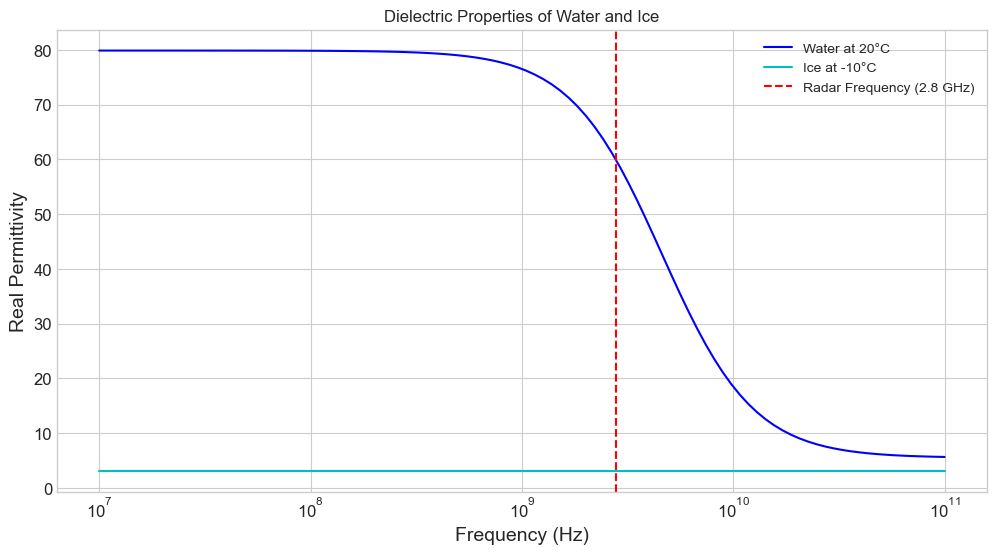

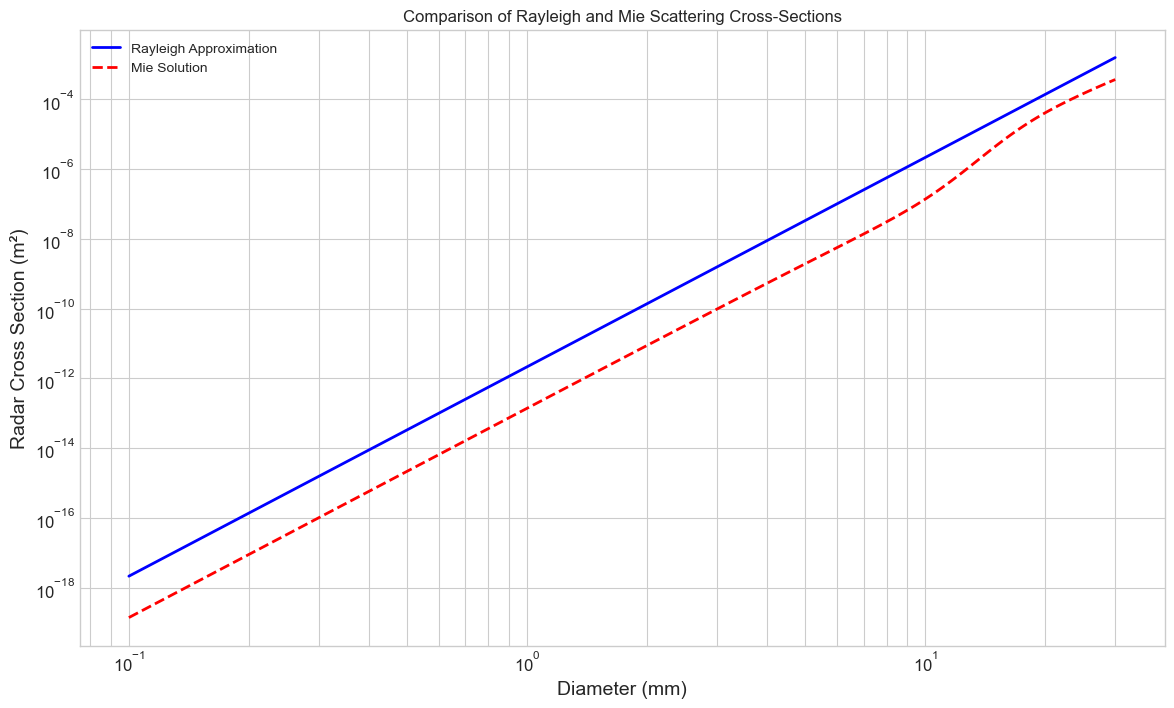

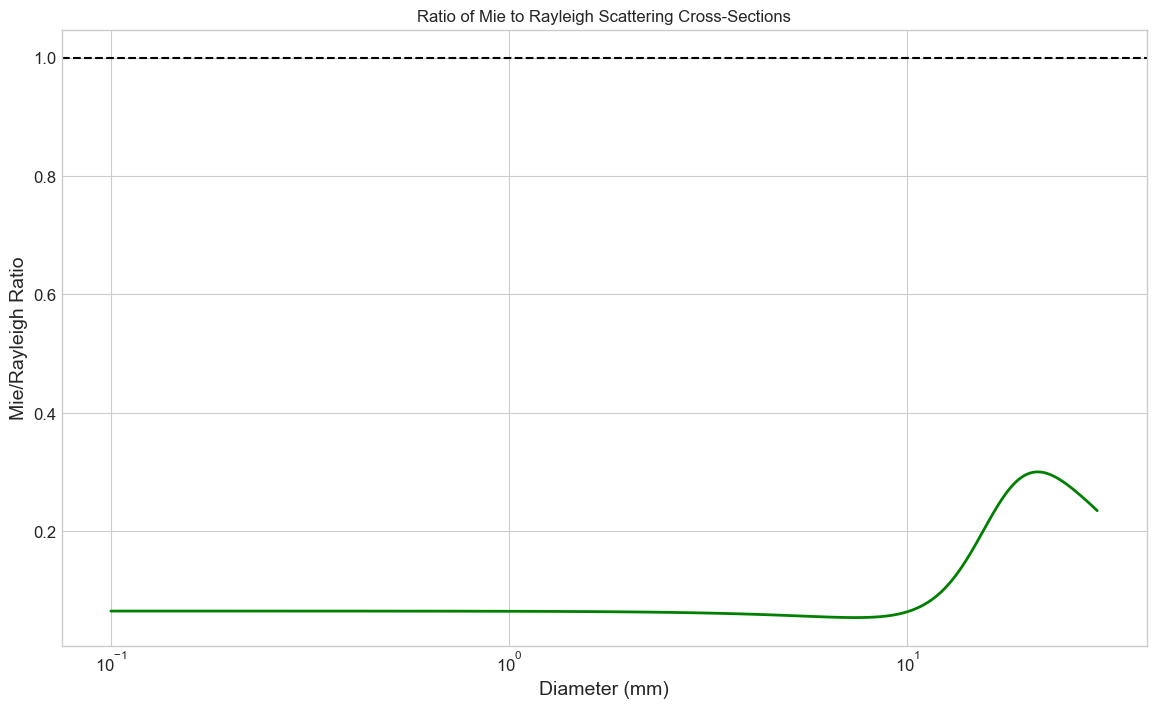

C:\Users\disha\AppData\Local\Temp\ipykernel_11920\1841055726.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  Z_values[i] = (sigma_b * radar_wavelength**4) / (np.pi**5 * k_w)


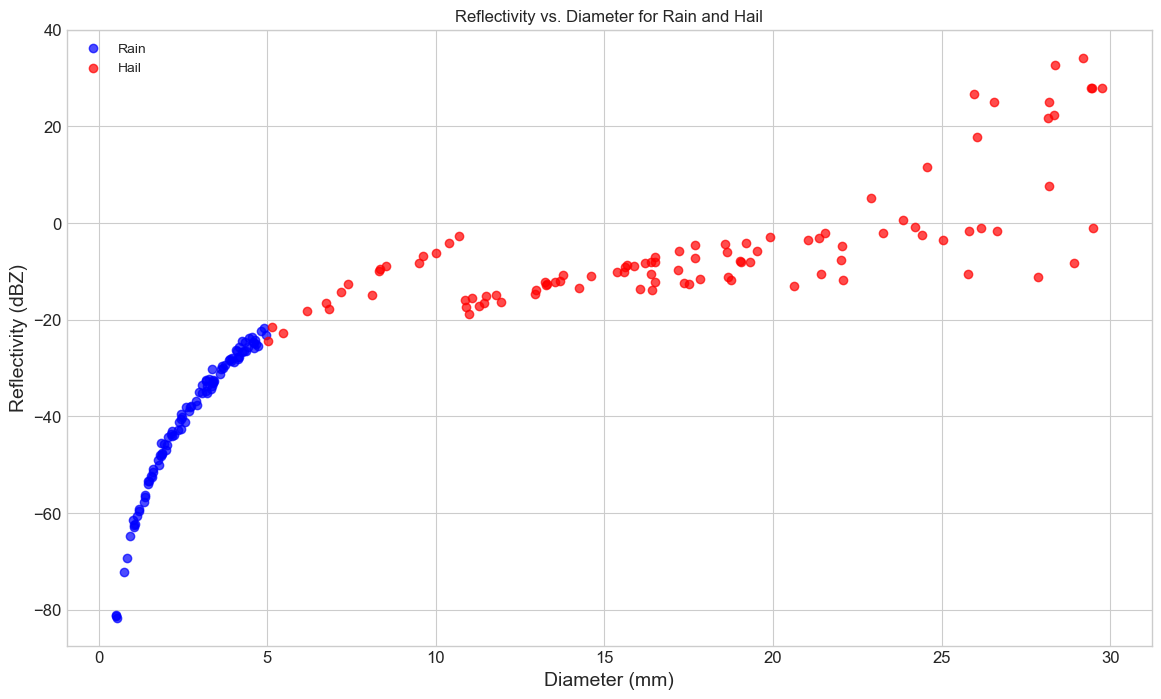

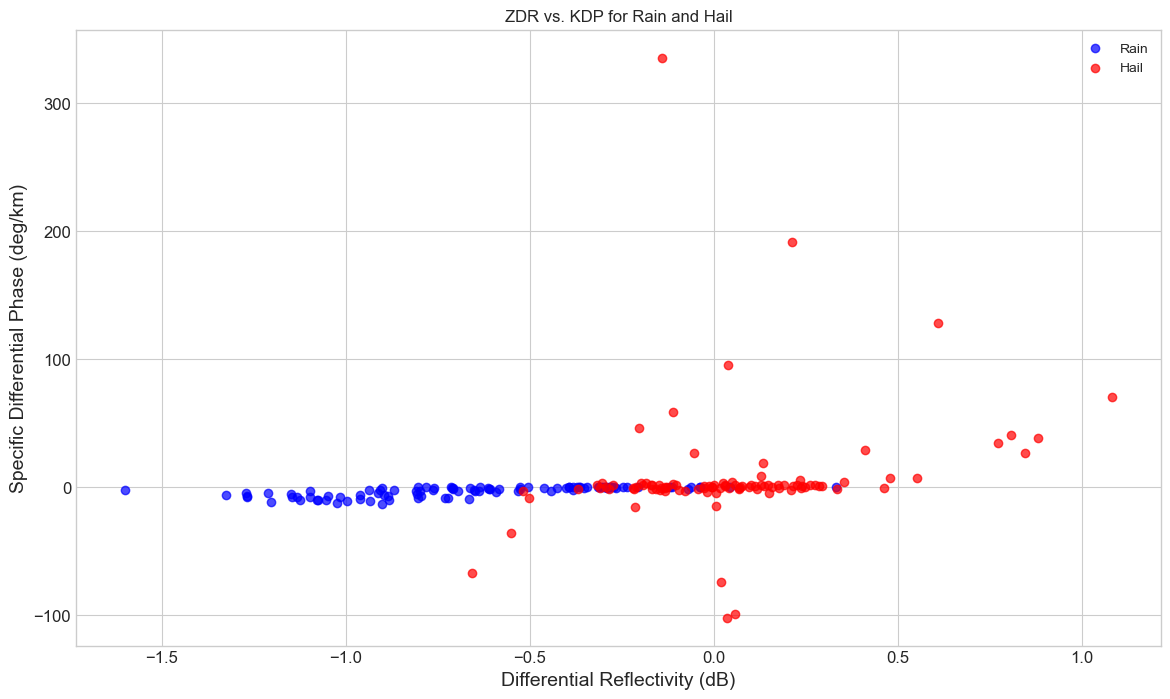

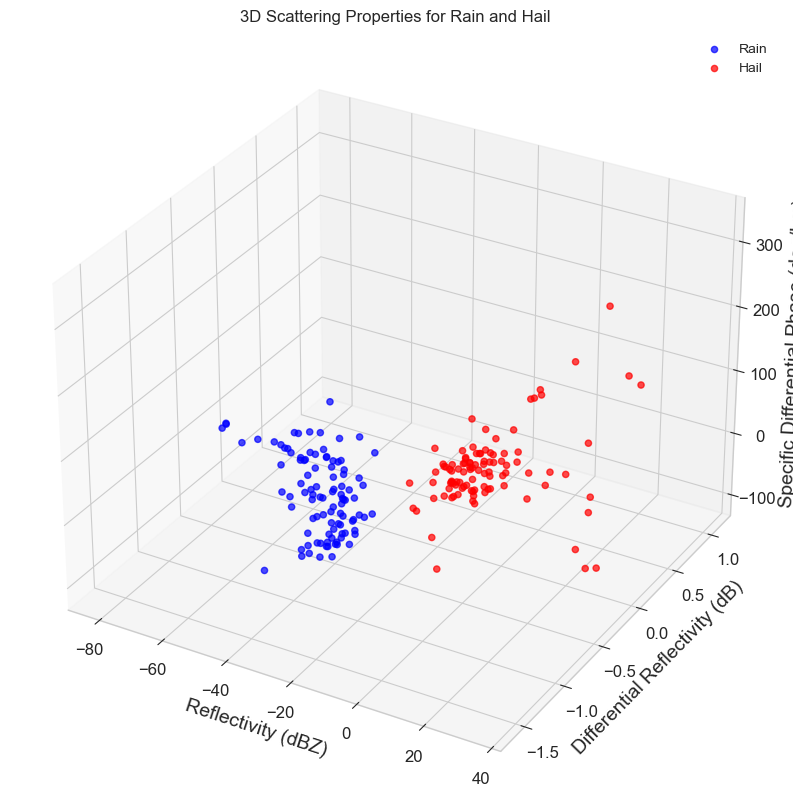

TypeError: float() argument must be a string or a real number, not 'complex'

In [28]:

# Main execution
if __name__ == "__main__":
    print("Starting electromagnetic scattering analysis...")
    
    # Display permittivity values
    water_freq_range = np.logspace(7, 11, 100)
    water_permittivity = [complex_permittivity_water(20, f).real for f in water_freq_range]
    ice_permittivity = [complex_permittivity_ice(-10, f).real for f in water_freq_range]
    
    plt.figure(figsize=(12, 6))
    plt.semilogx(water_freq_range, water_permittivity, 'b-', label='Water at 20°C')
    plt.semilogx(water_freq_range, ice_permittivity, 'c-', label='Ice at -10°C')
    plt.axvline(x=radar_freq, color='r', linestyle='--', label=f'Radar Frequency ({radar_freq/1e9:.1f} GHz)')
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Real Permittivity')
    plt.title('Dielectric Properties of Water and Ice')
    plt.legend()
    plt.grid(True)
    plt.savefig('dielectric_properties.png', dpi=300)
    plt.show()
    
    # Generate theoretical comparisons
    diameters, rayleigh_rcs, mie_rcs = compare_with_theory()
    
    # Analyze scattering properties
    df = analyze_scattering_properties()
    
    # Visualize FDTD simulations
    ez_scattered_rain, ez_scattered_hail = visualize_fdtd_simulation()
    
    # Generate and save synthetic dataset for use in later notebooks
    full_dataset = save_synthetic_dataset(1000, 'synthetic_radar_data.csv')
    
    print("Electromagnetic scattering analysis Complete")